In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:

import torch, torchvision
from torch import nn
import PIL
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchsummary import summary
import seaborn as sns
from torchvision.utils import save_image
from torch.utils.data import Dataset
from random import randint
import random
import pandas as pd
from skimage import io

from IPython.display import Image, display

import tqdm
import os
import logging
%matplotlib inline

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [ ]:
# Здесь мы преобразуем наш numpy.narray в картинку,
transforms_version1 = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor()
])

In [ ]:
transforms_version2 = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ColorJitter(hue=.07, saturation=.07),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ToTensor()
])

In [ ]:
batch_size = 32

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, csv_file : str, root_dir: str, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self) -> int:
    return len(self.annotations)

  def __getitem__(self,index: int) -> tuple:
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = io.imread(img_path, pilmode='RGBA')
        y_label = torch.tensor(int(self.annotations.iloc[index,2]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
dataset_pokemons_basic = CustomDataset(csv_file = 'pokemon.csv', root_dir = '/content/drive/My Drive/Colab Notebooks/images', transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(64)
]))

In [ ]:
def augmentation(times = 3):
    for time in range(times):
        tmp_1 = dataset_pokemons_transformed = CustomDataset(csv_file = 'pokemon.csv', root_dir = '/content/drive/My Drive/Colab Notebooks/images', transform = transforms_version1)
        tmp_2 = dataset_pokemons_transformed = CustomDataset(csv_file = 'pokemon.csv', root_dir = '/content/drive/My Drive/Colab Notebooks/images', transform = transforms_version2)
        if time == 0:
            tmp_total = torch.utils.data.ConcatDataset([tmp_1,tmp_2])
        else:
            tmp_total = torch.utils.data.ConcatDataset([tmp_total,tmp_1,tmp_2])
    return torch.utils.data.ConcatDataset([tmp_total, dataset_pokemons_basic])

In [ ]:
dataset_pokemons_total = augmentation()

In [ ]:
dataset_pokemons_total.__len__()

5656

In [ ]:
train_loader_pokemons = torch.utils.data.DataLoader(dataset = dataset_pokemons_total, batch_size = batch_size, shuffle = True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


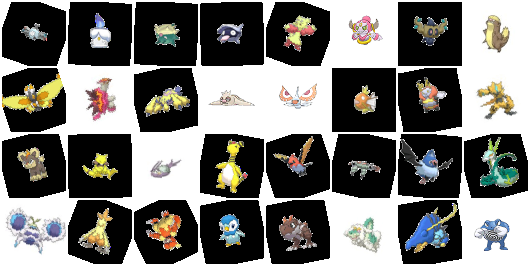

In [ ]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_loader_pokemons))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [ ]:
fixed_x.size()

torch.Size([32, 4, 64, 64])

In [ ]:
class Flatten(nn.Module):
    def forward(self, input: torch.tensor) -> torch.tensor:
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input : torch.tensor, size=1024) -> torch.tensor:
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class VAE_CNN(nn.Module):


    def __init__(self, image_channels=4, h_dim = 1024, z_dim = 32):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )



        self.decoder = nn.Sequential(

            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )

        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        self.z_2hid = nn.Linear(z_dim, h_dim)



    def reparametrize(self, mu: torch.tensor, sigma: torch.tensor) -> torch.tensor:
        std = torch.exp(0.5* sigma)
        eps = torch.rand_like(std)
        z = mu + eps*std
        return z

    def bottleneck(self, h: torch.tensor) -> tuple:
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        z_reparametrized = self.reparametrize(mu, sigma)
        return z_reparametrized, mu, sigma

    def encode(self, x: torch.tensor) -> tuple:
        h = self.encoder(x)
        z, mu, sigma = self.bottleneck(h)
        return z, mu, sigma

    def decode(self, z: torch.tensor) -> torch.tensor:
        z = self.z_2hid(z)
        z = self.decoder(z)
        return z

    def save_model(self, model: torch.nn):
        torch.save(model.state_dict(), "model_weights.pth") # сохраняем веса нащей модели в файл "model_weights.pth"

    def load_model(self) -> torch.nn:
        # загружаем веса нащей модели в файл "model_weights.pth"
        model = TheModelClass(*args, **kwargs)
        model.load_state_dict(torch.load("model_weights.pth"))
        return model

    def forward(self, x: torch.tensor) -> tuple:
        z, mu, sigma = self.encode(x)
        z = self.decode(z)
        return z, mu, sigma

In [ ]:
model_cnn = VAE_CNN().to(device)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)

In [ ]:
num_epochs = 50
model_cnn = model_cnn.to(device)

In [ ]:
def loss_fn(recon_x: torch.tensor, x: torch.tensor, mu: torch.tensor, sigma: torch.tensor) -> tuple:
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm.tqdm(enumerate(train_loader_pokemons))
    for i, (img, _) in loop:
        img = img.to(device)
        recon_images, mu, sigma = model_cnn(img)
        loss, bce, kld = loss_fn(recon_images, img, mu, sigma)
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

        loop.set_postfix(loss = loss.item(), bce = bce.item(), kld = kld.item(),)

177it [00:31,  5.64it/s, bce=4.98e+4, kld=18.4, loss=4.98e+4]
177it [00:31,  5.62it/s, bce=3.33e+4, kld=20.4, loss=3.33e+4]
177it [00:31,  5.56it/s, bce=3.56e+4, kld=21.2, loss=3.56e+4]
177it [00:31,  5.59it/s, bce=3.65e+4, kld=19.5, loss=3.65e+4]
177it [00:31,  5.60it/s, bce=4.63e+4, kld=18.9, loss=4.64e+4]
177it [00:31,  5.69it/s, bce=3.7e+4, kld=20.5, loss=3.7e+4]
177it [00:31,  5.66it/s, bce=4.41e+4, kld=18.5, loss=4.42e+4]
177it [00:31,  5.62it/s, bce=4.6e+4, kld=19.6, loss=4.6e+4]
177it [00:31,  5.56it/s, bce=3.83e+4, kld=18.2, loss=3.83e+4]
177it [00:31,  5.56it/s, bce=3.96e+4, kld=18.6, loss=3.96e+4]
177it [00:31,  5.59it/s, bce=4.24e+4, kld=19.4, loss=4.24e+4]
177it [00:32,  5.52it/s, bce=3.81e+4, kld=18.7, loss=3.82e+4]
177it [00:31,  5.54it/s, bce=4.48e+4, kld=16.3, loss=4.48e+4]
177it [00:31,  5.55it/s, bce=4.03e+4, kld=18.8, loss=4.03e+4]
177it [00:31,  5.67it/s, bce=4.08e+4, kld=18.2, loss=4.08e+4]
177it [00:31,  5.65it/s, bce=3.91e+4, kld=18.2, loss=3.91e+4]
177it [00:31

In [ ]:
model_cnn = model_cnn.to("cpu")

In [ ]:
model_cnn.save_model(model_cnn)

In [ ]:
def compare(x: torch.tensor) -> torch.tensor:
    recon_x, _, _ = model_cnn(x)
    return torch.cat([x, recon_x])

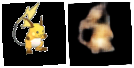

In [ ]:
fixed_x = dataset_pokemons_total[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

####  Уже лучше, однако детализации все равно не хватает